# This jupyter notebook contains an analysis example using [EmptyNN](https://github.com/lkmklsmn/empty_nn). The code reproduces the preprocessing analysis of singe-cell RNA sequencing data published by [Stoeckius et al](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1603-1), which we refer to as "cell hahing dataset" in our manuscript. 
### The following code runs in R environment. No requirment on R version. The libraries installed include EmptyNN, Seurat (for downstream analysis), ggplot2 (for visualization), DropletUtils (optional, for benchmarking analysis).

## Load R libraries

In [1]:
suppressMessages({library("EmptyNN")
                  library("Seurat")
                  library("pheatmap")
                  library("ggplot2")
                  # optional
                  library("DropletUtils")})

## Load cell hahing data from Stoeckius et al

### Option 1: The raw **cell hashing** datasets can be downloaded from [paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1603-1) or [GSE108313](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE108313). <br> Option 2: The RData file used in our analysis can be downloaded from [google drive](https://drive.google.com/file/d/12y0fW_Y9OdhBLns_2gpjo2Xq25c4qnGY/view?usp=sharing). It contains both the count matrix and label for each barcode.

In [6]:
path = "path_to_your_file"
load(paste0(path,"Stoeckius.RData"))

## We apply EmptyNN to do the preprocessing. 
### The input is raw count matrix, either in h5 or mtx format. The rows are barcodes and columns are genes. <br> The output is a boolean vector showing cell-free droplet (empty droplet) or cell-containing droplet.

### Runtime depends on the dataset to be processed and parameter setting. A higher k_folds or iteration means longer runtime. It takes ~30 mins to run with the default parameters. <br> For demonstration purposes, we set parameters to a low number, which takes ~5 mins.

In [9]:
nn.res <- emptynn(t(counts),threshold=50,k=2,iteration=1)
nn.keep <- nn.res$nn.keep

[1] "there are 11865 in P set"
[1] "there are 27977 in U set"
[1] "Samples in U set were split into 2 folds"
[1] "data normalization"
[1] "start training"
[1] "iteration 1"
[1] "training fold 1"
[1] "training fold 2"


## Next, we applied other state-of-art methods to benchmark our analysis, including [CellRanger 2.0](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger), [EmptyDrops](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1662-y), and [CellBender](https://cellbender.readthedocs.io/en/latest/getting_started/remove_background/).

### CellRanger 2.0

In [ ]:
n_counts <- colSums(counts)
ranger.keep <- n_counts>=200

### EmptyDrops

In [11]:
e.out <- emptyDrops(counts)
e.keep <- e.out$FDR <= 0.001

### CellBender <br> The processed cell hashing dataset by CellBender can be found at [Google Drive](https://drive.google.com/file/d/1BWvvMEQYfMlaTdYlIUzRVmqP19YW7AP4/view?usp=sharing).

In [4]:
bender <- Read10X_h5(paste0(path,"Stoeckius.CellBender_filtered.h5"))
bender.keep <- colnames(counts) %in% colnames(bender)
names(bender.keep) <- colnames(counts)

## To reproduce the results in the manuscript, we provided the result file used in the manuscript, available at [google drive](https://drive.google.com/file/d/1AXUzQEp1OJmZgLTwTHf1szqD-9nE092v/view?usp=sharing). It include the precessing results of four methods: nn.res, ranger.keep, e.keep, bender.keep. 

In [10]:
load(paste0(path,"Stoeckius_result.RData"))

## Next, we plot the barcode-rank plot and show recovered barcodes with low total counts by EmptyNN.

In [20]:
total_counts <- Matrix::colSums(counts)
aframe <- data.frame(total_counts, rank = rank(-total_counts), 
                     emptynn = nn.res$nn.keep)
twohundred <- unique(aframe$rank[which(aframe$total_counts == 200)])
fifty <- unique(aframe$rank[which(aframe$total_counts == 50)])
recovered <- aframe$rank[which(aframe$emptynn & 
                                       aframe$total_counts < 200 
                               & aframe$total_counts > 50)]
global <- ggplot(aframe, aes(rank, total_counts)) +
        scale_x_continuous(trans='log10') + scale_y_continuous(trans='log10') +
        geom_point() + theme_bw() +
        xlab("Sorted barcodes") + ylab("Total counts [log10]") +
        geom_vline(xintercept = twohundred, color = "dodgerblue", linetype = "dashed") +
        geom_vline(xintercept = fifty, color = "forestgreen", linetype = "dashed")

local <- ggplot(aframe[which(aframe$total_counts < 210 & aframe$total_counts > 40),], aes(rank, total_counts)) +
        xlab("Sorted barcodes") + ylab("Total counts [log10]") +
        geom_vline(xintercept = twohundred, color = "dodgerblue", linetype = "dashed") +
        geom_vline(xintercept = fifty, color = "forestgreen", linetype = "dashed") +
        geom_vline(xintercept = recovered, color = "darkred", alpha = 0.5) +
        geom_point() + theme_bw()

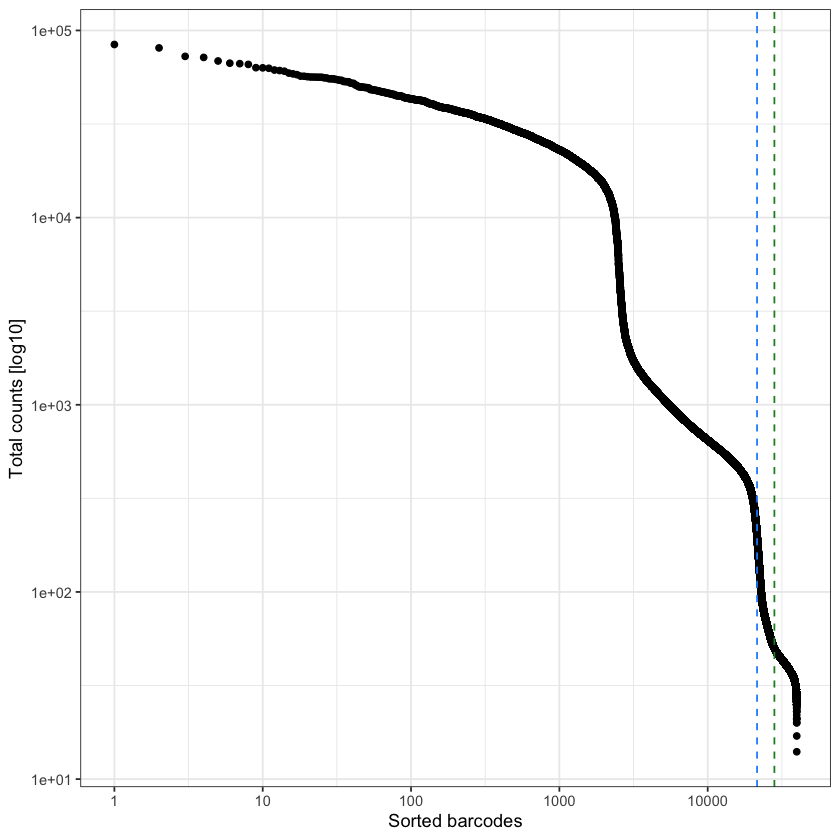

In [21]:
global

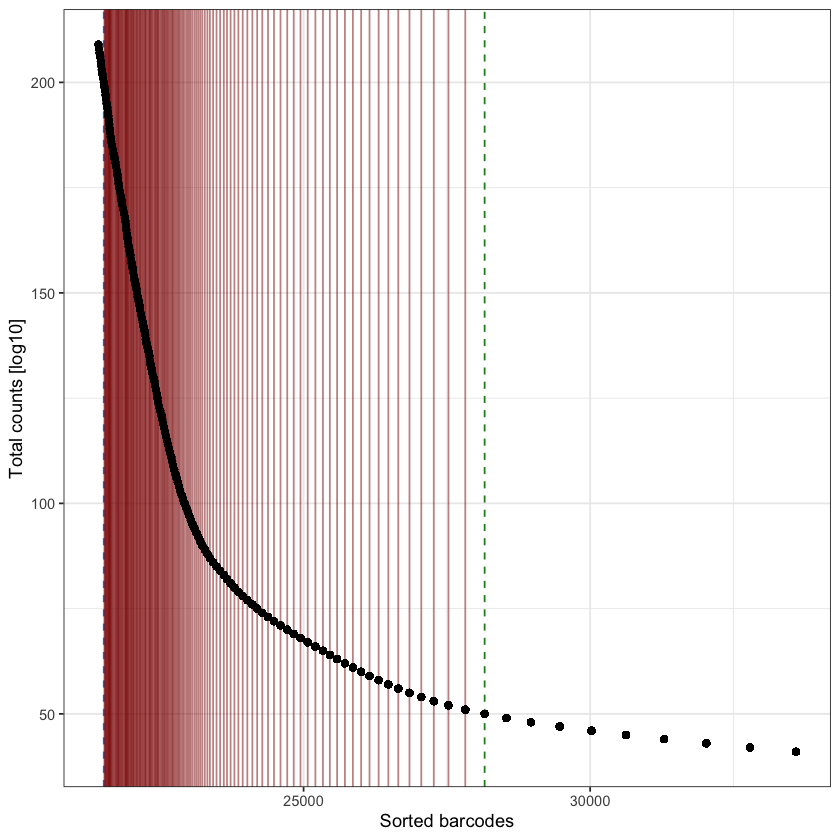

In [22]:
local

## tSNE plot of recovered low-count barcodes
### Seurat object of recovered low-count barcodes can be downloaded at [Google Drive](https://drive.google.com/file/d/1IrroxKEkfc6uHD2_wrINDyHd35AEDwsW/view?usp=sharing).

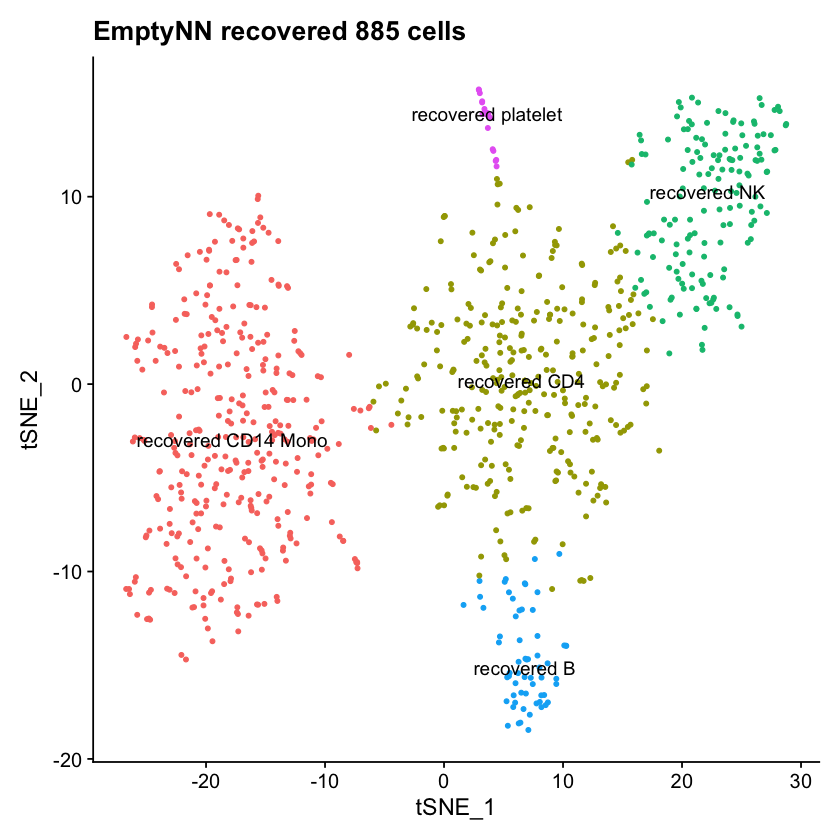

In [28]:
keep.vector <- nn.res
names(keep.vector) <- colnames(counts)
recover.bcs <- intersect(names(n_counts[n_counts<200]),names(keep.vector[keep.vector=="TRUE"]))
recover <- CreateSeuratObject(counts = counts[,recover.bcs])
recover <- NormalizeData(recover)
recover <- ScaleData(recover, features = genes.use)
recover <- RunPCA(recover,features=genes.use)
recover <- FindNeighbors(recover, dims = 1:10)
recover <- FindClusters(recover, resolution = 0.2)
recover <- RunTSNE(recover, dims = 1:10, check_duplicates = FALSE)
new.cluster <- c("recovered CD14 Mono","recovered CD4","recovered NK","recovered B cells","recovered platelet")
names(new.cluster) <- levels(recover)
recover <- RenameIdents(recover,new.cluster)
DimPlot(recover, label=TRUE)+labs(title="EmptyNN recovered 885 cells")+NoLegend()

## Benchmark analysis
### 1. AUROC curve

Setting levels: control = negative, case = singlet

Setting direction: controls < cases

Setting levels: control = negative, case = singlet

Setting direction: controls < cases

Setting levels: control = negative, case = singlet

Setting direction: controls < cases

Setting levels: control = negative, case = singlet

Setting direction: controls < cases



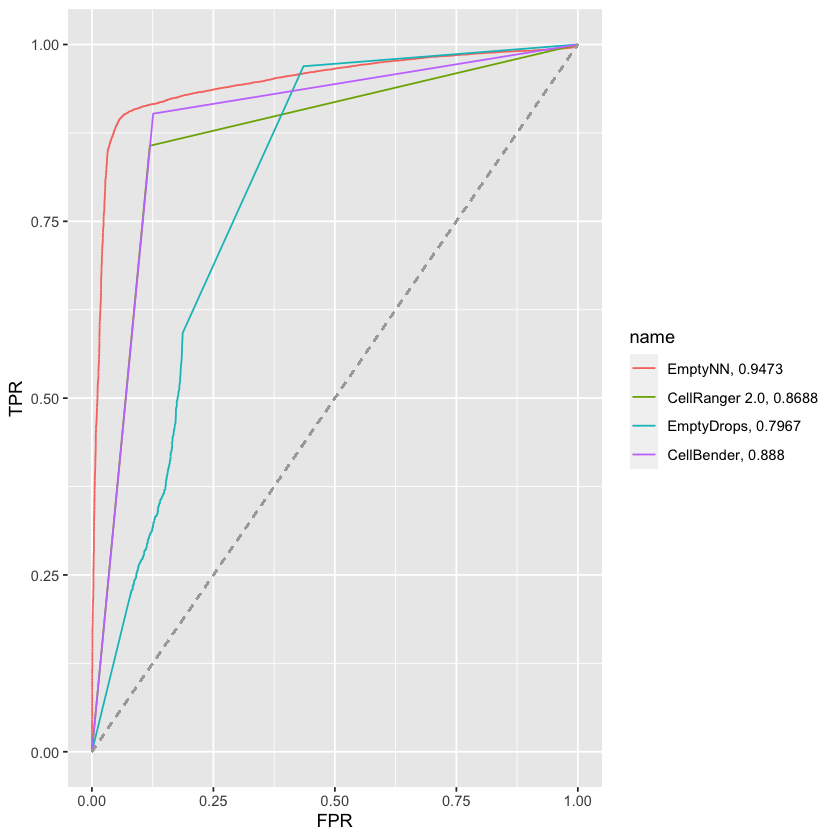

In [31]:
library('pROC')
label[,2] <- ifelse(label[,1]=="Negative","negative","singlet")
bcs <- rownames(nn.res$prediction)
rocobj1 <- roc(label[bcs,2], nn.res$prediction[bcs,'mean.crossval'])
rocobj2 <- roc(label[names(ranger.keep),2], as.numeric(ranger.keep))
bcs <- rownames(e.out[!is.na(e.out$FDR),])
rocobj3 <- roc(label[bcs,2], e.out[bcs,'FDR'])
rocobj4 <- roc(label[names(bender.keep),2], as.numeric(bender.keep))
ggroc(list("EmptyNN, 0.9473"=rocobj1,
           "CellRanger 2.0, 0.8688"=rocobj2,
           "EmptyDrops, 0.7967"=rocobj3,
           "CellBender, 0.888"=rocobj4),legacy.axes = TRUE) +
        labs(x = "FPR", y = "TPR")+
        geom_segment(aes(x = 0, xend = 1, y = 0, yend = 1), color="darkgrey", linetype="dashed")

### 2. Overall tSNE plot <br> The seurat object "retained" can be found in [Google Drive](https://drive.google.com/file/d/1leZ-hL8iiUMPn5fngyDt_KBlEnO067xu/view?usp=sharing).

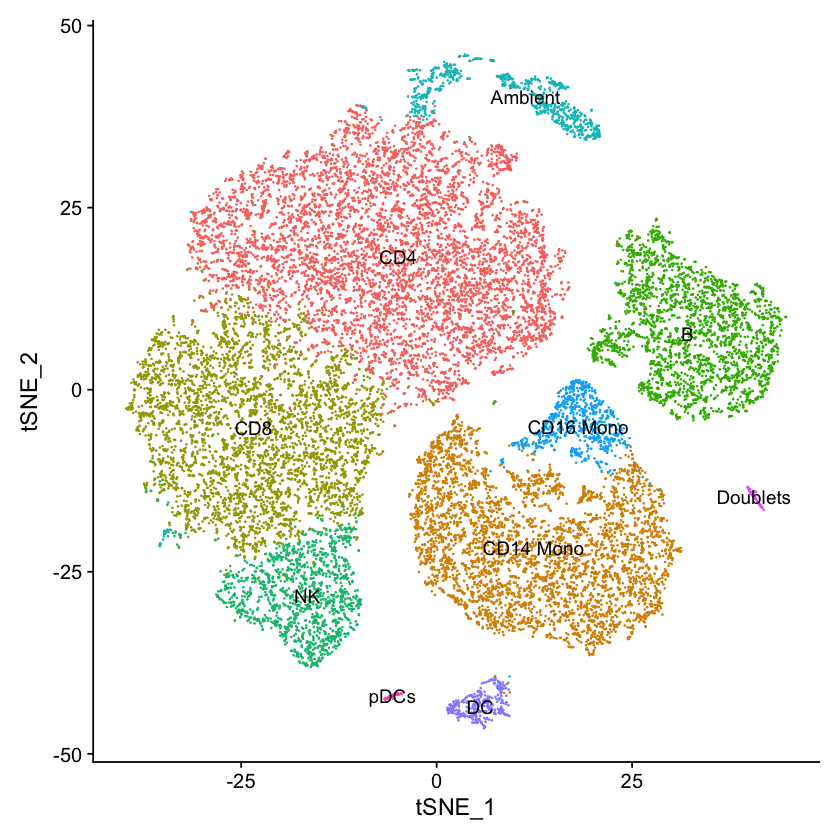

In [32]:
# keep <- nn.keep | ranger.keep | (e.keep & !is.na(e.keep)) | ranger.keep
# retained <- runSeurat(counts=counts[,keep],genes.use=genes.use,resolution=0.2)
# retained$emptynn <- colnames(retained) %in% colnames(counts)[nn.keep]
# retained$cellranger <- colnames(retained) %in% colnames(counts)[ranger.keep]
# retained$emptydrops <- colnames(retained) %in% colnames(counts)[e.keep & !is.na(e.keep)]
# retained$cellbender <- colnames(retained) %in% colnames(counts)[ranger.keep]
retained <- readRDS(paste0(path,"stoeckius_retained.rds"))
new.cluster <- c("CD4","CD14 Mono","CD8","B","NK",
                 "Ambient","CD16 Mono","DC","Doublets","pDCs")
names(new.cluster) <- levels(retained)
DimPlot(retained,label=TRUE,reduction = 'tsne')+NoLegend()

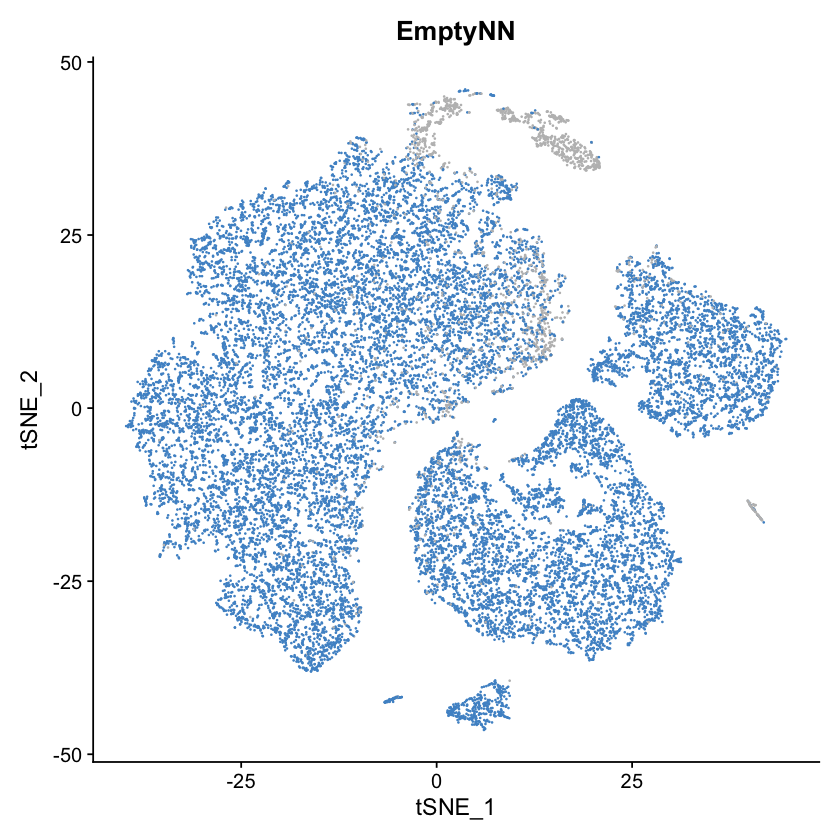

In [33]:
DimPlot(retained,group.by = 'emptynn',reduction = 'tsne',cols=c('grey','steelblue3'))+
        ggtitle("EmptyNN")+NoLegend()

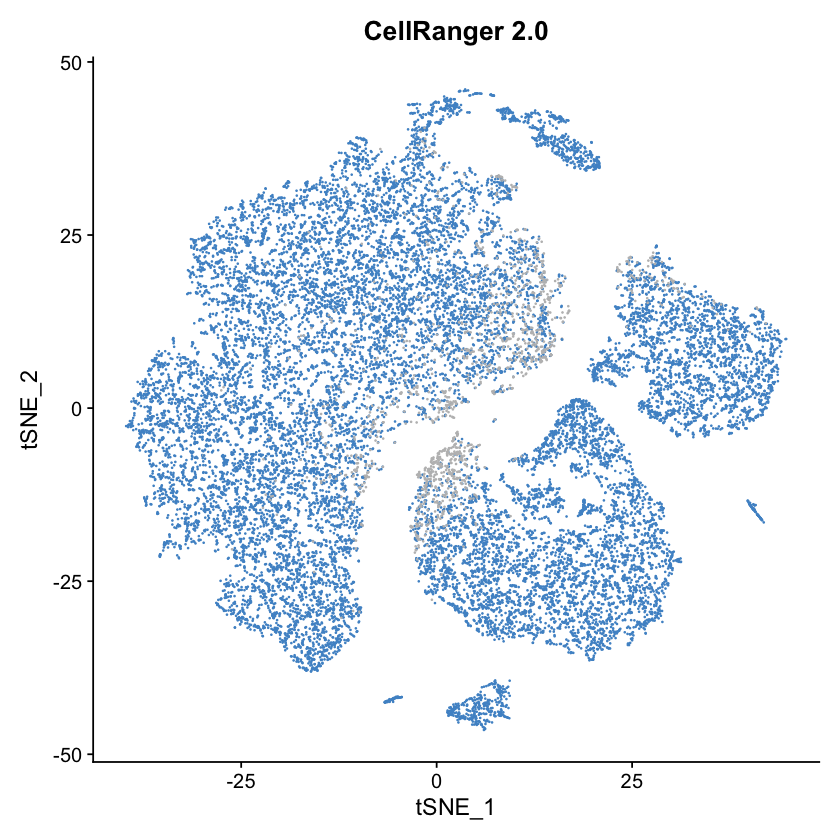

In [34]:
DimPlot(retained,group.by = 'cellranger',reduction = 'tsne',cols=c('grey','steelblue3'))+
        ggtitle("CellRanger 2.0")+NoLegend()

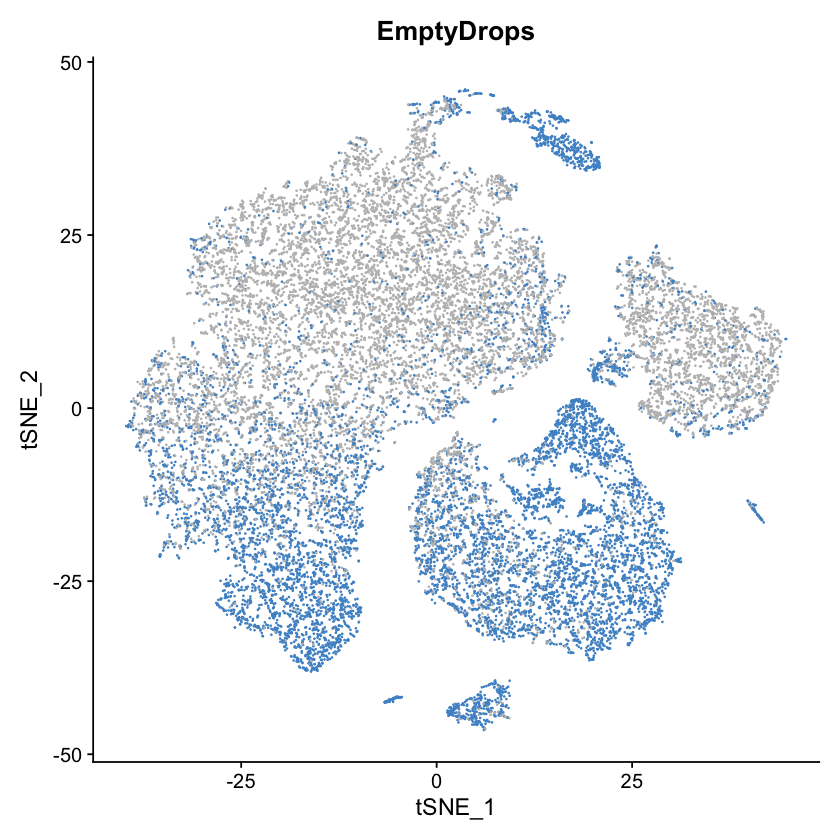

In [35]:
DimPlot(retained,group.by = 'emptydrops',reduction = 'tsne',cols=c('grey','steelblue3'))+
        ggtitle("EmptyDrops")+NoLegend()

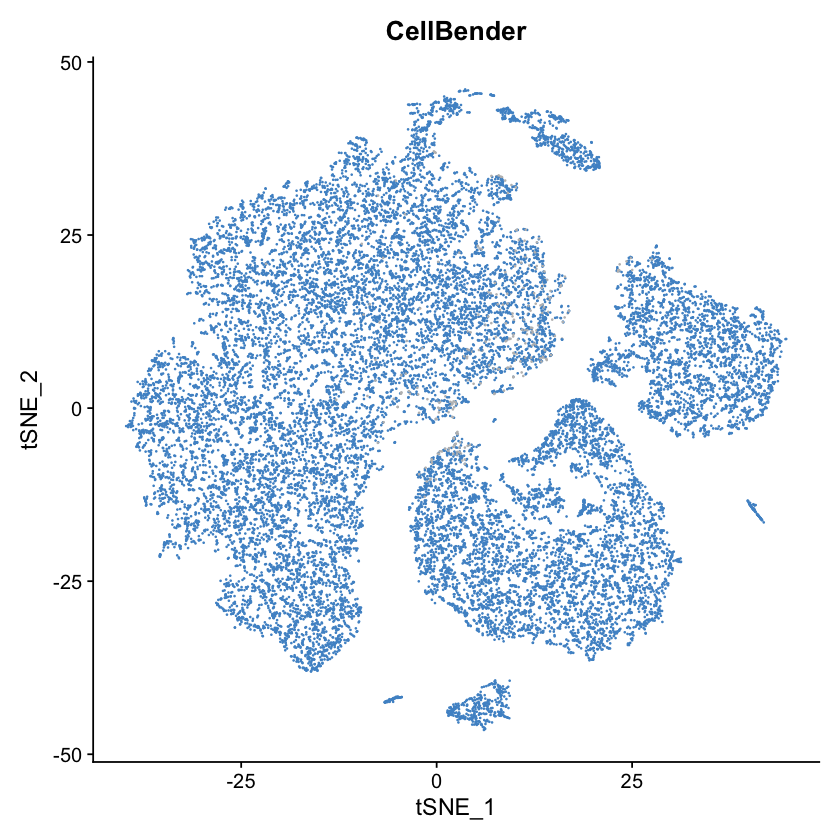

In [36]:
DimPlot(retained,group.by = 'cellbender',reduction = 'tsne',cols=c('grey','steelblue3'))+
        ggtitle("CellBender")+NoLegend()